# IMPORTS

In [ ]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import efficientnet.keras as efn

# LOADING DATASET

In [ ]:
(input_train, target_train), (input_test, target_test) = cifar100.load_data()

# ONE HOT ENCODING

In [ ]:
n_classes = 100

target_train = to_categorical(target_train, n_classes)
target_test = to_categorical(target_test, n_classes)

# SPLITTING INTO TRAINING AND VALIDATION

In [ ]:
#using stratified shuffle split to preserve the percentage of samples in each of the 100 classes
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(input_train, target_train):
    x_train_data, x_val_data = input_train[train_index], input_train[val_index]
    y_train_data, y_val_data = target_train[train_index], target_train[val_index]

# DATA PREPROCESSING

## Data Normalization

In [ ]:
x_train_data = x_train_data.astype('float32')
x_val_data = x_val_data.astype('float32')
input_test = input_test.astype('float32')

x_train_data = x_train_data/255
x_val_data = x_val_data/255
input_test = input_test/255


# MODEL CONFIGURATION

In [ ]:
batch_size = 100
loss_function = sparse_categorical_crossentropy
no_classes = 100
no_epochs = 15
optimizer = Adam(learning_rate = 0.0001)
validation_split = 0.2
verbosity = 1
img_width, img_height, img_num_channels = 32, 32, 3
input_shape = (img_width, img_height, img_num_channels)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

# PRETRAINED MODEL

In [ ]:
EFNB0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(EFNB0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1, 1, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


# MODEL COMPILING

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# MODEL TRAINING

In [ ]:
model_history = model.fit(x=input_train_std,
                            y=y_train_data,
                            batch_size= batch_size,
                            validation_data=(input_val_std,y_val_data),
                            callbacks=[early_stop, rlrop],
                            verbose=1,
                            epochs=no_epochs,
                            shuffle = True)

#saving the trained model weights as data file in .h5 format
model.save_weights("cifar_efficientnetb0_weights.h5")

Epoch 1/15
  65/5000 [..............................] - ETA: 20:18 - loss: 5.4380 - accuracy: 0.0077

KeyboardInterrupt: 

# PLOTTING

NameError: name 'model_history' is not defined

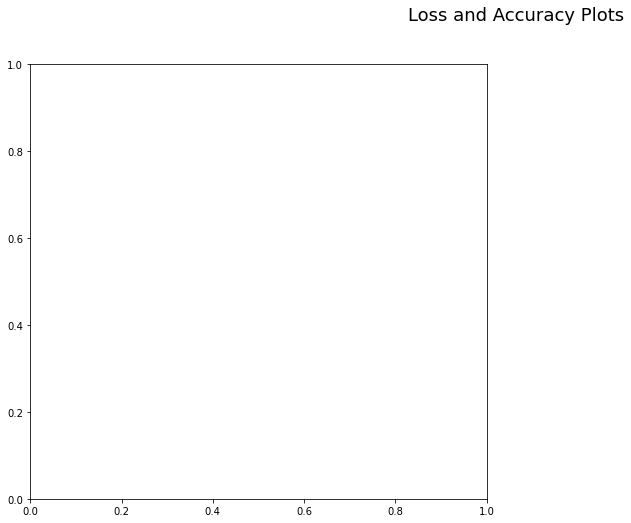

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

# MODEL EVALUATION

In [ ]:
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# PERFORMANCE MATRIX

## Model Prediction

In [ ]:
y_pred = model.predict(input_test,batch_size=10000)
predicted_labels = np.argmax(y_pred,axis=1)
target_test = target_test.reshape(10000,)

## Confusion Matrix

In [ ]:
CM = confusion_matrix(target_test, predicted_test)
print(CM)

## Plotting Confusion Matrix

In [ ]:
disp = ConfusionMatrixDisplay(CM,display_labels=None)
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='True')
plt.show()

## True Positives, True Negatives, False Positives, False Negatives

In [ ]:
FP = CM.sum(axis=0) - np.diag(CM)  
FN = CM.sum(axis=1) - np.diag(CM)
TP = np.diag(CM)
TN = CM.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

print(TP)
print(FN)
print(TN)
print(FP)

NameError: name 'CM' is not defined

## Accuracy

In [ ]:
ACC = (TP+TN)/(TP+FP+FN+TN)

print(ACC)